## В результате проверки (на отложенной тренировочной выборке) различных параметров в ходе экспериментов было выяснено, что лучшие параметры таковы:
* model_type = SGD
* step_alpha = 1
* step_beta = 0.001
* min_df = 2.5e-5
* preprocesser_type = BOW
    

In [1]:
import pickle
with open('GD_SGD_bow_tfid_min_df_without_stopwords.pkl', 'rb') as f:
    history_list = pickle.load(f)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

In [3]:
train_data = pd.read_csv('data_toxic/toxic_train.csv', index_col=0)
test_data = pd.read_csv('data_toxic/toxic_test.csv', index_col=0)

Text(0.5, 1, 'Распределение классов в трейне')

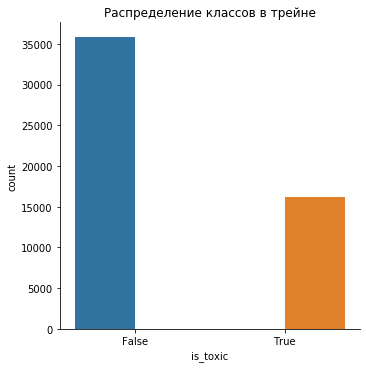

In [4]:
sns.catplot(x='is_toxic', data=train_data, hue='is_toxic', kind='count')
plt.title('Распределение классов в трейне')

In [5]:
target_train = train_data['is_toxic'].map({True : 1, False : -1})
train_data.drop(columns='is_toxic', inplace=True)

target_test = test_data['is_toxic'].map({True : 1, False : -1})
test_data.drop(columns='is_toxic', inplace=True)

In [6]:
train_data_processed_1 = train_data.copy()
test_data_processed_1 = test_data.copy()

In [7]:
import re

def text_process_1(texts_series):
    """
    Takes series with texts
    returns series with preprocessed texts
    (lower register + changed all symbols, which are not letter, number to spaces)
    """
    
    texts_series = texts_series.str.lower()
    texts_series = texts_series.apply(lambda x: re.sub(r'\W', ' ', x))
    return texts_series

In [8]:
train_data_processed_1 = text_process_1(train_data_processed_1['comment_text'])
test_data_processed_1 = text_process_1(test_data_processed_1['comment_text'])

In [9]:
import nltk
nltk.download('wordnet')
from nltk.corpus.reader.wordnet import VERB
lemmatizer = nltk.WordNetLemmatizer() 

[nltk_data] Downloading package wordnet to /home/paniquex/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
%%time
train_data_processed_lemmatized = train_data_processed_1.apply(lambda x: x.split()).apply(lambda x: [lemmatizer.lemmatize(elem, VERB) for elem in x])
test_data_processed_lemmatized = test_data_processed_1.apply(lambda x: x.split()).apply(lambda x: [lemmatizer.lemmatize(elem, VERB) for elem in x])

CPU times: user 11.5 s, sys: 88 ms, total: 11.6 s
Wall time: 11.6 s


In [11]:
from sklearn.feature_extraction.text import CountVectorizer

In [12]:
train_data_processed_3 = train_data_processed_lemmatized.apply(lambda x: ' '.join(x))
test_data_processed_3 = test_data_processed_lemmatized.apply(lambda x: ' '.join(x))
preprocesser = CountVectorizer(min_df=2.5e-5, lowercase=False)


train_data_processed_3 = preprocesser.fit_transform(train_data_processed_3)
test_data_processed_3 = preprocesser.transform(test_data_processed_3)

bias_feature_train = np.ones(train_data.shape[0])
bias_feature_test = np.ones(test_data.shape[0])
bias_feature_train = scipy.sparse.csr_matrix(bias_feature_train).T
bias_feature_test = scipy.sparse.csr_matrix(bias_feature_test).T
train_data_processed_3_with_bias = scipy.sparse.hstack([bias_feature_train, train_data_processed_3], 'csr')
test_data_processed_3_with_bias = scipy.sparse.hstack([bias_feature_test, test_data_processed_3], 'csr')

w_0 = np.zeros(train_data_processed_3_with_bias.shape[1])

In [13]:
import optimization

In [14]:
sgd_classifier = optimization.SGDClassifier(batch_size=1024,
                                            step_alpha=1,
                                            step_beta=0.001,
                                            max_iter = 10000,
                                            experiment = False,
                                            l2_coef=5e-5,
                                            tolerance=5e-7
                                            )

In [15]:
train_data_processed_3_with_bias

<52061x32272 sparse matrix of type '<class 'numpy.float64'>'
	with 2021651 stored elements in Compressed Sparse Row format>

In [16]:
%%time
sgd_classifier.fit(train_data_processed_3_with_bias, target_train.values)

CPU times: user 2min 25s, sys: 3.82 s, total: 2min 29s
Wall time: 18.7 s


In [18]:
%%time
sum(sgd_classifier.predict(test_data_processed_3_with_bias) == target_test.values) / target_test.shape[0]

CPU times: user 43.5 ms, sys: 46 µs, total: 43.5 ms
Wall time: 42.7 ms


0.8853743470690656

In [ ]:
0.8853743470690656

In [39]:
probs = sgd_classifier.predict_proba(test_data_processed_3_with_bias)

In [55]:
errors_mask = np.where(np.argmax(probs, axis=1) == 0, -1, 1) != target_test.values

In [60]:
test_data_processed_1[errors_mask], 

(1                          dear god this site is horrible 
 17              balance     this page has one sentence ...
 27       i will burn you to hell if you revoke my talk ...
 50       avg  plenty of greeks love the king  stop acti...
 56        this is just bizarre  ani medjool s abuse of ...
                                ...                        
 63515    as i am a teenager  i feel the need to say  sh...
 63636            yeah  sure  you say you welcome discus...
 63781             shut up and learn to sign your comments 
 63782                  baylor kids like to kill themselves
 63962            iran      that s right  iran  it was o...
 Name: comment_text, Length: 2370, dtype: object,
 array([[0.45312804, 0.54687196],
        [0.        , 1.        ],
        [0.08383635, 0.91616365],
        ...,
        [0.67678816, 0.32321184],
        [0.62992949, 0.37007051],
        [0.80037573, 0.19962427]]))

In [76]:
errors_with_high_prob_mask = np.where(probs[errors_mask].max(axis=1) > 0.85)[0]

In [124]:
[(i, target)
  for i, target in zip(test_data_processed_1[errors_with_high_prob_mask], target_test[errors_with_high_prob_mask]) 
         if 'not' in i]

[(' redslash  cut it short  if you have sources stating the rok is sovereign post them  otherwise please aknowledge wp is not the place to make or ',
  -1),
 ('               jews are not a race because you can only get it from your mother  your own mention of ethiopian jews not testing             as jews proves it is not  as well as the fact that we accept converts',
  -1),
 ('      not sure whether this is notable enough to be mentioned in the article  but you re right   versions later than 6  2001  can open files created by all previous versions  but save files only in its own format  with a suffix of    msx    where x is the version number  7  8  9  10  11  12      this is intentional  of course  besides  all versions but 7 save files in a compressed format   共产主义万岁   ',
  -1),
 ('    i m not convinced that he was blind  where is this documented  it s possible that he was just what we d call   legally blind   ie didn t have great vision  and that the name   blind blake   is an exa

In [114]:
indx = 2354
test_data_processed_1[errors_with_high_prob_mask][indx], target_test[errors_with_high_prob_mask][indx]

('   i didn t screw up  i lapsed  when you revert  you should examine what the previous editor did  as several reverters are doing  reverting again me at amin al husseini so blindly they do not notice they are removing intermediate edits involving correction of dates and spellings  it means that this is personal  or ideological  and not motivated by intelligent assessments of the merits ',
 -1)

## Доп. задание  №1

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [60]:
%%time
train_data_processed_3 = train_data_processed_lemmatized.apply(lambda x: ' '.join(x))
test_data_processed_3 = test_data_processed_lemmatized.apply(lambda x: ' '.join(x))
preprocesser = TfidfVectorizer(min_df=2.5e-5, lowercase=False, ngram_range=(1, 5))


train_data_processed_3 = preprocesser.fit_transform(train_data_processed_3)
test_data_processed_3 = preprocesser.transform(test_data_processed_3)

bias_feature_train = np.ones(train_data.shape[0])
bias_feature_test = np.ones(test_data.shape[0])
bias_feature_train = scipy.sparse.csr_matrix(bias_feature_train).T
bias_feature_test = scipy.sparse.csr_matrix(bias_feature_test).T
train_data_processed_3_with_bias = scipy.sparse.hstack([bias_feature_train, train_data_processed_3], 'csr')
test_data_processed_3_with_bias = scipy.sparse.hstack([bias_feature_test, test_data_processed_3], 'csr')

w_0 = np.zeros(train_data_processed_3_with_bias.shape[1])

CPU times: user 43.2 s, sys: 700 ms, total: 43.9 s
Wall time: 42.2 s


In [61]:
sgd_classifier = optimization.SGDClassifier(batch_size=1024,
                                            step_alpha=1,
                                            step_beta=0.001,
                                            max_iter = 10000,
                                            experiment = False,
                                            l2_coef=5e-5,
                                            tolerance=5e-7
                                            )

In [62]:
train_data_processed_3_with_bias

<52061x724326 sparse matrix of type '<class 'numpy.float64'>'
	with 6348427 stored elements in Compressed Sparse Row format>

In [63]:
%%time
sgd_classifier.fit(train_data_processed_3_with_bias, target_train.values)

CPU times: user 6min 22s, sys: 6.58 s, total: 6min 29s
Wall time: 48.7 s


In [64]:
%%time
sum(sgd_classifier.predict(test_data_processed_3_with_bias) == target_test.values) / target_test.shape[0]

CPU times: user 339 ms, sys: 15.8 ms, total: 354 ms
Wall time: 44.3 ms


0.8766686012768428

### Попробуем убрать приведение к одному регистру, так как капс может показывать некоторую агрессию

In [125]:
train_data_processed_1 = train_data.copy()
test_data_processed_1 = test_data.copy()

In [126]:
def text_process(texts_series):
    """
    Takes series with texts
    returns series with preprocessed texts
    (lower register + changed all symbols, which are not letter, number to spaces)
    """
    
    texts_series = texts_series.apply(lambda x: re.sub(r'\W', ' ', x))
    return texts_series

In [127]:
train_data_processed_1 = text_process(train_data_processed_1['comment_text'])
test_data_processed_1 = text_process(test_data_processed_1['comment_text'])

In [128]:
import nltk
nltk.download('wordnet')
from nltk.corpus.reader.wordnet import VERB
lemmatizer = nltk.WordNetLemmatizer() 

[nltk_data] Downloading package wordnet to /home/paniquex/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [129]:
%%time
train_data_processed_lemmatized = train_data_processed_1.apply(lambda x: x.split()).apply(lambda x: [lemmatizer.lemmatize(elem, VERB) for elem in x])
test_data_processed_lemmatized = test_data_processed_1.apply(lambda x: x.split()).apply(lambda x: [lemmatizer.lemmatize(elem, VERB) for elem in x])

CPU times: user 10.5 s, sys: 48 ms, total: 10.6 s
Wall time: 10.6 s


In [130]:
from sklearn.feature_extraction.text import CountVectorizer

In [138]:
train_data_processed_3 = train_data_processed_lemmatized.apply(lambda x: ' '.join(x))
test_data_processed_3 = test_data_processed_lemmatized.apply(lambda x: ' '.join(x))
preprocesser = CountVectorizer(min_df=2.5e-5, lowercase=False)


train_data_processed_3 = preprocesser.fit_transform(train_data_processed_3)
test_data_processed_3 = preprocesser.transform(test_data_processed_3)

bias_feature_train = np.ones(train_data.shape[0])
bias_feature_test = np.ones(test_data.shape[0])
bias_feature_train = scipy.sparse.csr_matrix(bias_feature_train).T
bias_feature_test = scipy.sparse.csr_matrix(bias_feature_test).T
train_data_processed_3_with_bias = scipy.sparse.hstack([bias_feature_train, train_data_processed_3], 'csr')
test_data_processed_3_with_bias = scipy.sparse.hstack([bias_feature_test, test_data_processed_3], 'csr')

w_0 = np.zeros(train_data_processed_3_with_bias.shape[1])

## Проверим на отложенной выборке:

In [85]:
sgd_classifier = optimization.SGDClassifier(batch_size=1024,
                                            step_alpha=1,
                                            step_beta=0.001,
                                            max_iter = 10000,
                                            experiment = True,
                                            l2_coef=5e-5,
                                            tolerance=5e-7
                                            )

In [86]:
%%time
history = sgd_classifier.fit(train_data_processed_3_with_bias, target_train.values, trace=True)

CPU times: user 9min 29s, sys: 10.8 s, total: 9min 40s
Wall time: 1min 12s


In [88]:
history['accuracy'][-1]

0.8879569754785838

Точность уменьшилась :( Проверим на тесте:

In [89]:
sgd_classifier = optimization.SGDClassifier(batch_size=1024,
                                            step_alpha=1,
                                            step_beta=0.001,
                                            max_iter = 10000,
                                            experiment = False,
                                            l2_coef=5e-5,
                                            tolerance=5e-7
                                            )

In [90]:
%%time
sgd_classifier.fit(train_data_processed_3_with_bias, target_train.values)

CPU times: user 9min 30s, sys: 15.9 s, total: 9min 46s
Wall time: 1min 14s


In [91]:
%%time
sum(sgd_classifier.predict(test_data_processed_3_with_bias) == target_test.values) / target_test.shape[0]

CPU times: user 352 ms, sys: 8.17 ms, total: 360 ms
Wall time: 44.9 ms


0.8766686012768428

 Тоже стала хуже :(

## Попробуем добавить новые признаки:

In [93]:
train_data

comment_text
0       Explanation\nWhy the edits made under my usern...
1       D'aww! He matches this background colour I'm s...
2       Hey man, I'm really not trying to edit war. It...
3       "\nMore\nI can't make any real suggestions on ...
4       You, sir, are my hero. Any chance you remember...
...                                                   ...
159494  "\n\n our previous conversation \n\nyou fuckin...
159514                  YOU ARE A MISCHIEVIOUS PUBIC HAIR
159541  Your absurd edits \n\nYour absurd edits on gre...
159546  "\n\nHey listen don't you ever!!!! Delete my e...
159554  and i'm going to keep posting the stuff u dele...

[52061 rows x 1 columns]

In [127]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_set = set(stopwords.words('english'))
import string

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/paniquex/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [128]:
# train_new_features = train_data.copy()


# train_new_features['count_sent']=train_data["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
# #Word count in each comment:
# train_new_features['count_word']=train_data["comment_text"].apply(lambda x: len(str(x).split()))
# #Unique word count
# train_new_features['count_unique_word']=train_data["comment_text"].apply(lambda x: len(set(str(x).split())))
# #Letter count
# train_new_features['count_letters']=train_data["comment_text"].apply(lambda x: len(str(x)))
# #punctuation count
# train_new_features["count_punctuations"] =train_data["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
# #upper case words count
# train_new_features["count_words_upper"] = train_data["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
# #title case words count
# train_new_features["count_words_title"] = train_data["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
# #Number of stopwords
# train_new_features["count_stopwords"] = train_data["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords_set]))
# #Average length of the words
# train_new_features["mean_word_len"] = train_data["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [129]:
# train_new_features.drop(columns='comment_text', inplace=True)

In [163]:
train_data_processed_3 = train_data_processed_lemmatized.apply(lambda x: ' '.join(x))
test_data_processed_3 = test_data_processed_lemmatized.apply(lambda x: ' '.join(x))
preprocesser = CountVectorizer(min_df=2.5e-5, lowercase=True)


train_data_processed_3 = preprocesser.fit_transform(train_data_processed_3)
test_data_processed_3 = preprocesser.transform(test_data_processed_3)

bias_feature_train = np.ones(train_data.shape[0])
bias_feature_test = np.ones(test_data.shape[0])
bias_feature_train = scipy.sparse.csr_matrix(bias_feature_train).T
bias_feature_test = scipy.sparse.csr_matrix(bias_feature_test).T
train_data_processed_3_with_bias = scipy.sparse.hstack([bias_feature_train, train_data_processed_3], 'csr')
test_data_processed_3_with_bias = scipy.sparse.hstack([bias_feature_test, test_data_processed_3], 'csr')

w_0 = np.zeros(train_data_processed_3_with_bias.shape[1])

In [141]:
# train_data_processed_3_with_bias = scipy.sparse.hstack([train_data_processed_3_with_bias, train_new_features], 'csr')

In [142]:
sgd_classifier = optimization.SGDClassifier(batch_size=1024,
                                            step_alpha=1,
                                            step_beta=0.001,
                                            max_iter = 10000,
                                            experiment = True,
                                            l2_coef=5e-5,
                                            tolerance=5e-7
                                            )

In [133]:
%%time
history = sgd_classifier.fit(train_data_processed_3_with_bias, target_train.values, trace=True)

CPU times: user 4min 17s, sys: 5.86 s, total: 4min 23s
Wall time: 33.1 s


In [137]:
history['accuracy'][-1]

0.73180101158845

In [136]:
train_new_features

count_sent  count_word  count_unique_word  count_letters  \
0                2          43                 41            264   
1                1          17                 17            112   
2                1          42                 39            233   
3                5         113                 82            622   
4                1          13                 13             67   
...            ...         ...                ...            ...   
159494          10         319                199           1677   
159514           1           6                  6             33   
159541           3          58                 46            346   
159546           3         103                 75            534   
159554           1          35                 33            182   

        count_punctuations  count_words_upper  count_words_title  \
0                       10                  2                 11   
1                       12                  1                  3   
2                        6                  0                  2   
3                       21                  5                  7   
4                        5                  0                  2   
...                    ...                ...                ...   
159494                  58                  8                 20   
159514                   0                  6                  1   
159541                   6                  0                  5   
159546                  30                  6                  8   
159554                   2                  0                  0   

        count_stopwords  mean_word_len  
0                    18       5.162791  
1                     2       5.588235  
2                    20       4.571429  
3                    56       4.486726  
4                     5       4.230769  
...                 ...            ...  
159494              138       4.241379  
159514                3       4.666667  
159541               30       4.948276  
159546               54       4.184466  
159554               11       4.228571  

[52061 rows x 9 columns]

In [106]:
0.8683014277482554
0.8879569754785838

<52061x32276 sparse matrix of type '<class 'numpy.float64'>'
	with 2204291 stored elements in Compressed Sparse Row format>

Снова плохо :(

### Попробуем сделать так: будем сохранять лучшие веса, с которыми модель показала лучшую точность на отложенной выборке

In [145]:
sgd_classifier = optimization.SGDClassifier(batch_size=1024,
                                            step_alpha=1,
                                            step_beta=0.001,
                                            max_iter = 10000,
                                            experiment = True,
                                            l2_coef=5e-5,
                                            tolerance=5e-7,
                                            save_best_weights=True
                                            )

In [146]:
%%time
history = sgd_classifier.fit(train_data_processed_3_with_bias, target_train.values, trace=True)

CPU times: user 4min 13s, sys: 5.77 s, total: 4min 19s
Wall time: 32.6 s


In [147]:
max(history['accuracy'])

0.9108777770663935

In [148]:
sgd_classifier.w = history['best_weights']

In [149]:
%%time
sum(sgd_classifier.predict(test_data_processed_3_with_bias) == target_test.values) / target_test.shape[0]

CPU times: user 44.9 ms, sys: 19 µs, total: 44.9 ms
Wall time: 43.8 ms


0.8804894563745406

### Попробуем использовать кросс-валидацию:

In [78]:
from sklearn.model_selection import KFold, StratifiedKFold

In [97]:
n_splits = 5
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)
i = 1
preds = None
w_0 = np.zeros(train_data_processed_3_with_bias.shape[1])
val_score_list = []
for trn_idx, valid_idx in kfold.split(train_data_processed_3_with_bias, target_train.values):
    sgd_classifier = optimization.SGDClassifier(batch_size=512,
                                            step_alpha=1,
                                            step_beta=0.001,
                                            max_iter = 10000,
                                            experiment = False,
                                            l2_coef=0,
                                            tolerance=5e-7,
                                            save_best_weights=False,
                                            )
    history = sgd_classifier.fit(train_data_processed_3_with_bias[trn_idx],
                                 target_train.values[trn_idx], trace=True, w_0=w_0)
    val_score_list.append(np.sum(sgd_classifier.predict(train_data_processed_3_with_bias[valid_idx]) == target_train.values[valid_idx]) / valid_idx.shape[0])
    print(f'Fold: {i}, \
          accuracy: {val_score_list[-1]}')
    i += 1
    if preds is None:
        preds = sgd_classifier.predict_proba(test_data_processed_3_with_bias) / n_splits
    else:
        preds += sgd_classifier.predict_proba(test_data_processed_3_with_bias) / n_splits

print(f'Mean accuracy: {np.mean(val_score_list)}')    

Fold: 1,           accuracy: 0.9129983867250518
Fold: 2,           accuracy: 0.9143713264953325
Fold: 3,           accuracy: 0.9182897314740117
Fold: 4,           accuracy: 0.916676270600438
Fold: 5,           accuracy: 0.9148224988473951
Fold: 6,           accuracy: 0.9167819271553711
Mean accuracy: 0.9156566902162667


In [98]:
np.sum(np.where(np.argmax(preds, axis=1) == 0, -1, 1) == target_test) / target_test.shape[0]

0.8902592377635906

1.0

In [41]:
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_auc_score

In [100]:
def sgd_bayesian(step_alpha,
                 step_beta,
                 batch_size, l2_coef,  X_valid=None, y_valid=None):
    batch_size = int(batch_size)
    sgd_classifier = optimization.SGDClassifier(batch_size=batch_size,
                                            step_alpha=step_alpha,
                                            step_beta=step_beta,
                                            max_iter = 5000,
                                            experiment = True,
                                            l2_coef=l2_coef,
                                            tolerance=5e-7,
                                            save_best_weights=False
                                            )
    
    history = sgd_classifier.fit(train_data_processed_3_with_bias,
                                 target_train.values, trace=True, w_0=w_0)
    
    score = history['accuracy'][-1]
    return score

In [235]:
def sgd_bayesian_kfold(step_alpha,
                 step_beta,
                 batch_size, l2_coef,  X_valid=None, y_valid=None): 
    n_splits = 5
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)
    i = 1
    preds = None
    batch_size = int(batch_size)
    w_0 = np.zeros(train_data_processed_3_with_bias.shape[1])
    val_score_list = []
    for trn_idx, valid_idx in kfold.split(train_data_processed_3_with_bias, target_train.values):
        sgd_classifier = optimization.SGDClassifier(batch_size=batch_size,
                                                step_alpha=step_alpha,
                                                step_beta=step_beta,
                                                max_iter = 10000,
                                                experiment = False,
                                                l2_coef=l2_coef,
                                                tolerance=5e-7,
                                                save_best_weights=False,
                                                )
        history = sgd_classifier.fit(train_data_processed_3_with_bias[trn_idx],
                                     target_train.values[trn_idx], trace=True, w_0=w_0)
        val_score_list.append(np.sum(sgd_classifier.predict(train_data_processed_3_with_bias[valid_idx]) == target_train.values[valid_idx]) / valid_idx.shape[0])
        print(f'Fold: {i}, \
              accuracy: {val_score_list[-1]}')
        i += 1
#         if preds is None:
#             preds = sgd_classifier.predict_proba(test_data_processed_3_with_bias) / n_splits
#         else:
#             preds += sgd_classifier.predict_proba(test_data_processed_3_with_bias) / n_splits
    return np.mean(val_score_list)
#     print(f'Mean accuracy: {np.mean(val_score_list)}')    

In [236]:
bounds_sgd = {
    'step_alpha': (0.0, 10.0),
    'step_beta': (0.0, 5),
    'l2_coef': (0, 1e-4),
    'batch_size': (128,2000)
}

sgd_BO = BayesianOptimization(sgd_bayesian_kfold, bounds_sgd, random_state=13)

In [237]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    sgd_BO.maximize(init_points=500, n_iter=500, acq='ucb')

|   iter    |  target   | batch_... |  l2_coef  | step_a... | step_beta |
-------------------------------------------------------------------------
Fold: 1,               accuracy: 0.7115144530874868
Fold: 2,               accuracy: 0.69054936611602
Fold: 3,               accuracy: 0.6943910872070688
Fold: 4,               accuracy: 0.7043795620437956
Fold: 5,               accuracy: 0.7018824433346139
|  1        |  0.7005   |  1.584e+0 |  2.375e-0 |  8.243    |  4.829    |
Fold: 1,               accuracy: 0.7077691347354269
Fold: 2,               accuracy: 0.7052439492892816
Fold: 3,               accuracy: 0.7005378409527468
Fold: 4,               accuracy: 0.702362658470995
Fold: 5,               accuracy: 0.7138878217441413
|  2        |  0.706    |  1.949e+0 |  4.534e-0 |  6.09     |  3.878    |
Fold: 1,               accuracy: 0.7540574282147315
Fold: 2,               accuracy: 0.7594122166730696
Fold: 3,               accuracy: 0.7551863234729159
Fold: 4,               accuracy

Fold: 2,               accuracy: 0.7610449481367653
Fold: 3,               accuracy: 0.7624855935459086
Fold: 4,               accuracy: 0.7873607376104494
Fold: 5,               accuracy: 0.7729542835190165
|  22       |  0.7736   |  505.5    |  1.757e-0 |  4.371    |  1.701    |
Fold: 1,               accuracy: 0.7275520983386152
Fold: 2,               accuracy: 0.725989243180945
Fold: 3,               accuracy: 0.710238186707645
Fold: 4,               accuracy: 0.7196504033807145
Fold: 5,               accuracy: 0.7110065309258548
|  23       |  0.7189   |  1.939e+0 |  1.43e-05 |  8.446    |  3.347    |
Fold: 1,               accuracy: 0.8557572265437434
Fold: 2,               accuracy: 0.8503649635036497
Fold: 3,               accuracy: 0.8528620822128313
Fold: 4,               accuracy: 0.8422973492124471
Fold: 5,               accuracy: 0.8517095658855167
|  24       |  0.8506   |  332.6    |  8.825e-0 |  9.665    |  0.9715   |
Fold: 1,               accuracy: 0.735234802650533
F

Fold: 1,               accuracy: 0.7052722558340536
Fold: 2,               accuracy: 0.6944871302343449
Fold: 3,               accuracy: 0.6955436035343834
Fold: 4,               accuracy: 0.6998655397618133
Fold: 5,               accuracy: 0.6903572800614676
|  44       |  0.6971   |  146.4    |  9.942e-0 |  1.324    |  3.463    |
Fold: 1,               accuracy: 0.7280322673581101
Fold: 2,               accuracy: 0.6917979254706108
Fold: 3,               accuracy: 0.6942950441797926
Fold: 4,               accuracy: 0.6970802919708029
Fold: 5,               accuracy: 0.6948713023434498
|  45       |  0.7012   |  753.8    |  1.802e-0 |  1.406    |  3.346    |
Fold: 1,               accuracy: 0.8463459137616441
Fold: 2,               accuracy: 0.843930080676143
Fold: 3,               accuracy: 0.8424894352669996
Fold: 4,               accuracy: 0.8393200153668844
Fold: 5,               accuracy: 0.8479638878217441
|  46       |  0.844    |  696.8    |  6.137e-0 |  9.356    |  1.015    |

Fold: 5,               accuracy: 0.8867652708413369
|  65       |  0.8852   |  357.7    |  7.824e-0 |  0.5685   |  0.3163   |
Fold: 1,               accuracy: 0.6907711514453088
Fold: 2,               accuracy: 0.6924702266615443
Fold: 3,               accuracy: 0.6942950441797926
Fold: 4,               accuracy: 0.6918939684978871
Fold: 5,               accuracy: 0.6927583557433731
|  66       |  0.6924   |  931.0    |  9.666e-0 |  2.168    |  4.74     |
Fold: 1,               accuracy: 0.6917314894842985
Fold: 2,               accuracy: 0.6907414521705724
Fold: 3,               accuracy: 0.7027468305800999
Fold: 4,               accuracy: 0.6956396465616597
Fold: 5,               accuracy: 0.6999615827890895
|  67       |  0.6962   |  208.6    |  8.882e-0 |  5.653    |  4.111    |
Fold: 1,               accuracy: 0.7832517046000192
Fold: 2,               accuracy: 0.7721859393008068
Fold: 3,               accuracy: 0.7885132539377642
Fold: 4,               accuracy: 0.773242412600845

Fold: 2,               accuracy: 0.8619861698040723
Fold: 3,               accuracy: 0.8607376104494814
Fold: 4,               accuracy: 0.8688052247406838
Fold: 5,               accuracy: 0.8621782558586246
|  87       |  0.8625   |  302.6    |  7.913e-0 |  3.964    |  0.7265   |
Fold: 1,               accuracy: 0.6927878613271872
Fold: 2,               accuracy: 0.6906454091432962
Fold: 3,               accuracy: 0.6948713023434498
Fold: 4,               accuracy: 0.6933346139070303
Fold: 5,               accuracy: 0.6902612370341913
|  88       |  0.6924   |  1.972e+0 |  1.19e-05 |  1.41     |  4.27     |
Fold: 1,               accuracy: 0.7790262172284644
Fold: 2,               accuracy: 0.7791010372646946
Fold: 3,               accuracy: 0.7765078755282366
Fold: 4,               accuracy: 0.7605647330003842
Fold: 5,               accuracy: 0.7785247791010372
|  89       |  0.7747   |  1.49e+03 |  6.913e-0 |  6.214    |  2.165    |
Fold: 1,               accuracy: 0.759723422644771

KeyboardInterrupt: 

In [238]:
sgd_BO.max

{'target': 0.9145040632481658,
 'params': {'batch_size': 698.3683175311135,
  'l2_coef': 1.3623338112195127e-05,
  'step_alpha': 6.9425005759855205,
  'step_beta': 0.2643310099176238}}

In [239]:
# {'target': 0.9158076701453358,
#  'params': {'batch_size': 1923.624192726998,
#   'l2_coef': 0.0,
#   'step_alpha': 16.744882359611136,
#   'step_beta': -1.0120822997912522}}
w_0 = np.zeros(train_data_processed_3_with_bias.shape[1])

In [240]:
sgd_classifier = optimization.SGDClassifier(batch_size=698,
                                            step_alpha=6.942,
                                            step_beta=0.264,
                                            max_iter = 10000,
                                            experiment = False,
                                            l2_coef=0,
                                            tolerance=5e-7,
                                            save_best_weights=False,
                                            )

In [241]:
# sgd_classifier = optimization.SGDClassifier(batch_size=256,
#                                             step_alpha=1,
#                                             step_beta=0.001,
#                                             max_iter = 10000,
#                                             experiment = False,
#                                             l2_coef=5e-5,
#                                             tolerance=5e-7
#                                             )

In [242]:
%%time
sgd_classifier.fit(train_data_processed_3_with_bias,
                   target_train.values, trace=True, w_0=w_0)

CPU times: user 1min 23s, sys: 2.01 s, total: 1min 25s
Wall time: 10.7 s


{'epoch_num': [0,
  1,
  2.0055511803461368,
  3.011102360692257,
  4.016653541038378,
  5.022204721384532,
  6.027755901730686,
  7.033307082076839,
  8.038858262422991,
  9.044409442769078,
  10.049960623115165,
  11.055511803461252,
  12.06106298380734,
  13.066614164153426,
  14.072165344499513,
  15.0777165248456,
  16.083267705191698,
  17.08881888553792,
  18.09437006588414,
  19.09992124623036,
  20.10547242657658,
  21.1110236069228,
  22.11657478726902,
  23.12212596761524,
  24.12767714796146,
  25.13322832830768,
  26.1387795086539,
  27.14433068900012,
  28.14988186934634,
  29.15543304969256,
  30.160984230038782,
  31.166535410385002,
  32.172086590731176,
  33.17763777107713,
  34.183188951423084,
  35.18874013176904,
  36.19429131211499,
  37.199842492460945,
  38.2053936728069,
  39.21094485315285,
  40.21649603349881,
  41.22204721384476,
  42.227598394190714,
  43.23314957453667,
  44.23870075488262,
  45.244251935228576,
  46.24980311557453,
  47.25535429592048,
  

In [244]:
%%time
sum(sgd_classifier.predict(test_data_processed_3_with_bias) == target_test.values) / target_test.shape[0]

CPU times: user 48.3 ms, sys: 0 ns, total: 48.3 ms
Wall time: 47.5 ms


0.8884213580963436

In [ ]:
0.8918069259044302

In [122]:
from sklearn.linear_model import SGDClassifier

In [222]:
svc_classifier = SGDClassifier(max_iter=10000, tol=1e-7, l1_ratio=0.1, random_state=13, alpha=0.0005)

In [223]:
svc_classifier.fit(train_data_processed_3_with_bias, target_train.values)

SGDClassifier(alpha=0.0005, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.1, learning_rate='optimal', loss='hinge',
              max_iter=10000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=13, shuffle=True, tol=1e-07,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [224]:
%%time
sum(svc_classifier.predict(test_data_processed_3_with_bias) == target_test.values) / target_test.shape[0]

CPU times: user 42.4 ms, sys: 204 µs, total: 42.6 ms
Wall time: 42.1 ms


0.8848906945250532

In [227]:
svm_894_name = 'svm_894_model'
with open(svm_894_name, 'rb') as f:
    svc_classifier = pickle.load(f)

In [230]:
preds_1 = svc_classifier.predict(test_data_processed_3_with_bias)

In [232]:
preds_1

array([-1,  1, -1, ...,  1, -1,  1])